<a href="https://colab.research.google.com/github/MELAI-1/WORKSHOPS-AND-SCIENTIFIC-OUTREACH/blob/main/%20I-X%20AI%20in%20Science-Imperial/Key%20Challenges%20in%20Applying%20Machine%20Learning%20to%20Materials%20Science.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The purpose of this tutorial is to get you familiar with core challenges that arise when applying machine to materials science. The assessment is in a different notebook given in session 2 and will build on the problems/examples highlighted here

# Key Challenges in Applying Machine Learning to Materials Science

There are three main challenges when applying machine learning models to materials science problems:



1.  Small, sparse and biased datasets
2.  Complex, high-dimensional descriptors
3.  Need for physically interpretable models

### Small, sparse and biased datasets

Experimental and simulation data in materials science are often limited in size, noisy, and collected under inconsistent conditions. Data may be biased toward well-studied systems, leaving large regions of materials space underexplored. These limitations make it difficult to train robust and generalisable ML models. Careful preprocessing, feature selection, and validation are essential to avoid overfitting and misleading conclusions.

### Complex, high-dimensional descriptors

Materials often exhibit behaviour across multiple scales -- from atomic to macroscopic -- making it difficult to represent them with simple features. Descriptors need to capture structural, electronic, and thermodynamic information, which are often high-dimensional and interdependent. Constructing meaningful representations that reflect the underlying physics is a critical step in building effective models.

### Importance of physically interpretable models

In materials science, it is not enough for a model to be accurate -- it must also make sense physically. Researchers need to understand why a model makes a certain prediction, particularly when it suggests new materials for synthesis or application. Incorporating domain knowledge, using interpretable models, and applying techniques like feature importance analysis or SHAP values can help build trust and extract insight from ML predictions.

Finally, uncertainty quantification is especially important in this context. Given the high cost of experimental validation, models should not only make predictions but also express confidence in them -- enabling better decision-making and resource allocation.

This notebook will guide you through several examples of how to manage materials data using machine learning models, including how featurising materials properties work, and how to apply clustering techniques to different datasets in order to build a predictive model.

 ## Example 1: Predicting bulk modulus with simple features
Her you will look at supervised learning by working with a dataset containing the bulk modulus of over 10,000 inorganic crystals. This is a regression problem, where our goal is to predict a continuous property rather than classify materials into discrete categories.

## What is the Bulk Modulus?

Imagine squeezing a material--how much does it resist compression? The [bulk modulus](https://en.wikipedia.org/wiki/Bulk_modulus) (B) quantifies this resistance and is a key preoperty in materials science. It is defined as:

$
B = -V \frac{\partial P}{\partial V} = V \frac{\partial^2 E}{\partial V^2}
$

Where $B$ is GPa, $E$ is the energy of the material, $P$ is the pressure, and $V$ is the volume. For example, diamond has has a measured bulk modulus of $B$ = 443 GPa at T = 4 K. The bulk modulus is a useful quantity in models of materials bonding, thermodynamics, and mechanics.

## How will AI help us?

Rather than manually calculating bulk modulus values, we can train a machine learning model to predict them based on the material properties. We will use the Python package `matminer` (https://matminer.readthedocs.io) to access the materials dataset and featurise the data in a form that is suitable for statistical analysis and building machine learning models. We will use the computational materials science package `pymatgen` (https://pymatgen.org) that powers the [Materials Project](https://materialsproject.org).

In [ ]:
# Installation of libraries
!pip install optimade --quiet
!pip install matminer --quiet
!pip install elementembeddings --quiet
!pip install pymatviz --quiet
!pip install plotly --quiet

In [ ]:
# Basic utilities
import pprint  # Pretty print data structures
import warnings  # Warning control
import numpy as np # Numerical operations
#from numpy import ComplexWarning  # Warning for complex numbers

# Data handling
import pandas as pd  # Data manipulation with DataFrames
from monty.serialization import loadfn  # Load serialised data

# Materials science
from pymatgen.core import Structure  # Materials analysis for crystal structures
import matminer  # Materials informatics
from matminer.datasets.dataset_retrieval import load_dataset  # Load materials datasets

# Visualisation
import matplotlib.pyplot as plt  # Plotting
import seaborn as sns  # Statistical visualisation
plt.style.use('ggplot')  # Set Matplotlib style to 'ggplot'

# Warning management
#warnings.filterwarnings("ignore", category=ComplexWarning)  # Ignore ComplexWarning

# Performance adjustments
teaching_mode = True  # To make models run faster

<details>
<summary>Colab error solution</summary>
If running the import module cell fails with an "AttributeError", click `Runtime` -> `Restart Session` and then simply rerun the cell.
</details>

## Bulk moduli dataset

From `matminer`, we can check what datasets are available using the `datasets.get_available_datasets()` method.

In [ ]:
# Print the available datasets
matminer.datasets.get_available_datasets(print_format='low')

We can use the get_all_dataset_info function from the matminer.datasets.dataset_retrieval module to output a detailed description of a matminer dataset. Let's check the information for the matbench_log_kvrh dataset.

Here "K" relates to the bulk modulus (which we called  𝐵 ), and and "VRH" relates to the Voigt-Reuss-Hill equation of state, which is one approach to define a value for each material.

In [ ]:
print(matminer.datasets.dataset_retrieval.get_all_dataset_info('matbench_log_kvrh'))

We can then load a dataset using the `load_dataset` method.

In [ ]:
# Use matminer to download the dataset
df = load_dataset('matbench_log_kvrh')
print(f'The full dataset contains {df.shape[0]} entries. \n')

if teaching_mode:
  # Store the original DataFrame as a copy
  full_dataset_df = df.copy()
  # Create a subset of the original DataFrame for demonstration purposes
  df = df.sample(n=1500, random_state=41)
  print(f'For teaching purposes we will only work with {df.shape[0]} entries from the DataFrame to make the model training and testing faster. \n')

print('The DataFrame is shown below:')
df.head(10)

### Visualise the target variable

We can use `df.describe()` to produce summary statistics of the numerical columns. The importance of this is to check whether the data for our target variable, `log10(K_VRH)`, is reasonable. Negative values for the bulk modulus are considered unphysical and forbidden by crystal thermodynamics. You can think about why from the definition.

As we are working with `log10` of the bulk modulus, it should not be possible for there to be negative values in our target variable column as the logarithm of a negative number is undefined. This also gives us a quick check for the input data.

In [ ]:
df.describe()

From the summary statistics, the minimum value for `log10(K_VRH)` is zero, so it appears that there are no glaring issues with the target variable.  

For a better understanding, let's make a histogram to visualise the distribution. This is best practice when you encounter any new dataset.

In [ ]:
# Plot a histogram
fig, ax = plt.subplots(figsize=(5,3))
ax.hist(df['log10(K_VRH)'])
ax.set_xlabel(r'$log_{10}K_{VRH}$ [$log_{10}GPa$]')
ax.set_ylabel('Counts')
plt.show()

## Features of materials
As you may notice from the dataset, we only have one input feature, the crystal structure. This is not a numerical feature that we can use for a regression model. For supervised machine learning, we must represent each material by a vector that can be used as an input to the model, e.g.

$$f(\textrm{material}) \rightarrow [1.1,0.8,3.5,0.01]$$

would be a four-dimensional representation.
For now we will use some pre-selected features from `matminer` for this regression task. There are many ways to represent materials, but details about differents sorts of materials representations are beyond the scope of this course.

### Composition-based features

To use the `ElementProperty` featuriser, we first need to add a `pymatgen.core.composition.Composition` object to our DataFrame. There are several ways to do this but we will proceed using the `composition` property of the pymatgen `Structure` class.

In [ ]:
from matminer.featurizers.composition.composite import ElementProperty
from matminer.featurizers.structure.order import DensityFeatures

# Add a composition column to df using the composition property of the Structure class and a lambda function
df['composition'] = df.structure.apply(lambda x: x.composition )
df.head()

The new composition column contains both the elements and the amount of each element in the composition. Let's use the `ElementProperty` featuriser to add some composition-based features to our dataset.

In [ ]:
# Create the ElementProperty featuriser
el_prop_featuriser = ElementProperty.from_preset(preset_name='magpie')

# By default multiprocessing is enabled, however this has been known to slow performance on some systems, so we disable it
el_prop_featuriser.set_n_jobs(1)

# Apply the ElementProperty featuriser
df = el_prop_featuriser.featurize_dataframe(df, col_id='composition')

# Print the shape of the DataFrame
print(df.shape)
df.head()

There are now a lot more columns in the DataFrame. We can check the reference for a property featuriser using the `.citations()` method as shown below.

In [ ]:
el_prop_featuriser.citations()

### Structure-based features

Within `matminer`, there are many featurisers which operate on crystal structures. We will add some simple features based on the density of the structures using `DensityFeatures`. We will return to these later in the module.

In [ ]:
# Crystal structure to vector
density_featuriser = DensityFeatures()
density_featuriser.set_n_jobs(1)
df=density_featuriser.fit_featurize_dataframe(df, col_id='structure')

df.head()

## Bulk modulus regression

With regression tasks, we want to fit a model that maps our input feature $x$ to our target variable $y$, i.e. $y=f(x)$. Here, $x$ and $y$ are vectors of dimensions $M$ and $N$, respectively, such that $f: \mathbb{R}^M\rightarrow\mathbb{R}^N$.  

Supervised machine learning problems generally take the following form:
* Select a form for the model $f$
* Determine an error/loss function that is used to evaluate model performance
* Optimise the parameters of the model to minimise the error

The error, $L(\hat{y},y)$, is a function of the predicted target variable $\hat{\textbf{y}}=f(\textbf{x})$ and the true target variable, $\textbf{y}$. We want our model to minimise $L$.

For our problem. the target variable is `log(K_VRH)`, which we want to predict from knowledge of the composition and structure (represented by the set of chosen features).

We can make extensive use of `scikit-learn` (https://scikit-learn.org) for these tasks.

### Data preparation

To start, we need to split our dataset into the target variable `log10(K_VRH)` and the input features. For the input features, we must remove any non-numerical data.

In [ ]:
# Define the features we want to keep
features_to_drop = ['structure','composition','log10(K_VRH)']
feature_cols = [col for col in list(df.columns) if col not in features_to_drop]

# Get an array of the features
X = df[feature_cols].values

# Get an array of the target variable
y = df['log10(K_VRH)'].values

print(f'Shape of X: {X.shape}')
print(f'Shape of y: {y.shape}')

We can also check the names of the features used for our model.


In [ ]:
print(f'We have {len(feature_cols)} features in our dataset.')
print(feature_cols)

### Baseline linear regression model
A simple model is the linear regressor.  For a univariate linear regressor represented by $\hat{y}=mx+c$, the task is to find the best value of $m$ and $c$ that minimise the model error.

If we were to consider multivariate linear regression, then our equation transforms to $\hat{y}=\beta_0 + ∑_1^n\beta_ix_i$, where $\beta_i$ are the weights of the model and $x_i$ are the input features.

In [ ]:
# Import linear regression model
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Fit the model to the data
lr = LinearRegression()
lr.fit(X, y)

def make_prediction_plot(X, y, model, label):
    """
    Plot and return predictions for the given model and data.

    Parameters:
    X : Input features.
    y : Actual target values.
    model : Fitted model.
    label : Descriptor for the axes labels.

    Returns:
    Predicted values.
    """
    y_pred = model.predict(X)
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.scatter(y, y_pred, c=y, cmap='viridis')
    ax.plot(y, y, 'r-')
    ax.set_xlabel(f'{label} true')
    ax.set_ylabel(f'{label} predicted')
    plt.show()

    return y_pred

# Make predictions using the fitted model
y_pred = make_prediction_plot(X, y, lr, 'log10(K_VRH)')

Note how prediction errors tend to be higher for extreme values – this may reflect the model struggling with sparse data in certain regions of the materials space.

In [ ]:
from sklearn import metrics

# Mean absolute error
print (f'The training MAE = {metrics.mean_absolute_error(y,y_pred):.3f} log10GPa')

# Mean squared error
print(f'The training RMSE = {metrics.root_mean_squared_error(y,y_pred):.3f} log10GPa')

# $r^2$ - coefficient of determination
print(f'The training r^2 = {lr.score(X,y):.3f}')

Based on your analysis, is this a useful model?

### Random forest regressor

We can do better with a non-linear model. Let's try a machine learning regressor. [Random forest](https://en.wikipedia.org/wiki/Random_forest) is an ensemble machine learning algorithm that combines multiple [decision trees](https://en.wikipedia.org/wiki/Decision_tree) to improve predictive accuracy.

Random forest can be applied to both classification and regression tasks. The prediction is made by taking a majority vote (for classification) or averaging (for regression) of the predictions from individual trees. Mathematically, it can be represented as:

$
\hat{y}_{RF} = \frac{1}{n_{trees}} \sum_{i=1}^{n_{trees}} f_i(x)
$

where:
- $\hat{y}_{RF}$ is the random forest prediction.
- $n_{trees}$ is the number of decision trees in the forest.
- $f_i(x)$ represents the prediction of the $i$-th tree.

#### 1. Create the regressor

In `sklearn`, the random forest regressor is created by:

```python
RandomForestRegressor(n_estimators=<int>, criterion=<str>, max_depth=<int>, min_samples_split=<int>, min_samples_leaf=<int>)
```

The hyperparameters that need to be set are:
* `n_estimators`: number of decision trees in the random forest model.
* `criterion`: loss function to be minimised. Default value is 'squared_error` which is the MSE.
* `max_depth`: maximum depth of the tree.
* `min_sample_split`: minimum number of samples required to split an internal node.
* `min_samples_leaf`: minimum number of samples required to be at a leaf node.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Define the model
rf = RandomForestRegressor(n_estimators=100,criterion='squared_error', max_depth=None, min_samples_split=2, min_samples_leaf=1, random_state=42)

# Fit the model
rf.fit(X,y)

<details>
<summary> Why is the random state set to 42?</summary>
Most random number generators start with an initial seed value and then produces a sequence of numbers that appears random. Since the algorithms are deterministic, providing the same seed will result in the same sequence of "random" numbers. 42 is simply a science fiction reference.
</details>

You just trained a machine learning model 🎉.  

We can now make predictions and plot the results. We will use the plotting function `make_prediction_plot()` that we defined earlier to make the plots.

In [ ]:
print("Linear regression")
y_pred_lr = make_prediction_plot(X,y,lr,'log10(K_VRH)')

print("Random Forest model")
y_pred = make_prediction_plot(X,y,rf,'log10(K_VRH)')

Now let's quantify the performance of the random forest model:

In [ ]:
# Print the metrics
print(f'The training MAE = {metrics.mean_absolute_error(y,y_pred):.3f} log10GPa')
print(f'The training RMSE = {metrics.root_mean_squared_error(y,y_pred):.3f} log10GPa')
print(f'The training r^2 = {rf.score(X,y):.3f}')

The coefficient of determination, $r^2$, as well as the low RMSE suggest that this model is performs well. However, it is also likely that the model is simply overly-fitted to reproduce the training data. This means that it will not generalise to other materials (unseen data), which is necessary for a meaningful machine learning model.

#### 2. Cross validation
To better determine the quality of our model, we can peform cross-validation (CV). CV enables us to evaluate the out-of-sample goodness-of-fit of a regressor. We will use $k$-fold CV, which splits the training set into $k$ subsets. Each subset is used as a validation set to evaluate the performance, with the model being trained on the remaining $k-1$ subsets.

Let's perform 5-fold CV:

In [ ]:
from sklearn.model_selection import KFold, cross_val_score, cross_validate

# Define the number of splits for cross-validation
n_splits = 5 if teaching_mode else 10

# Compute the cross-validation score
cv = KFold(
    n_splits=n_splits,
    shuffle=True,
    random_state=42
    )

scores= cross_val_score(rf, X, y,cv=cv, scoring='neg_mean_absolute_error')

r2_scores = cross_val_score(rf, X, y, cv=cv, scoring='r2')

print('From our cross-validation, we have obtained the following results:')
print(f'mean MAE = {np.mean(np.abs(scores)):.3f} log10GPa')
print(f'mean r^2 = {np.mean(np.abs(r2_scores)):.3f}')

In [ ]:
# Show the training scores for each k-fold
fig, ax = plt.subplots(2, 1, figsize=(5, 4))

ax[0].scatter([i for i in range(len(scores))], np.abs(scores), c=scores, cmap='viridis')
ax[1].scatter([i for i in range(len(r2_scores))], np.abs(r2_scores), c=r2_scores, cmap='viridis')
ax[0].set_xlabel('Training fold')
ax[0].set_ylabel('MAE')
ax[0].set_ylim(0, 0.14)
ax[0].set_xticks(range(len(scores)))
ax[1].set_xticks(range(len(r2_scores)))
ax[1].set_xlabel('Training fold')
ax[1].set_ylabel('r$^2$')
ax[1].set_ylim(0, 1.0)

# Display the plot
plt.show()

There is an increase in the error (decrease in performance) for the CV model. However, the MAE is still reasonable. Let's visualise the result of the final model:

In [ ]:
from sklearn.model_selection import cross_val_predict

# Plot the original and predicted data against each other
fig, ax = plt.subplots(figsize=(5, 3))

# Scatter plot with color
ax.scatter(y, cross_val_predict(rf, X, y, cv=cv), c=y, cmap='viridis', label='Predicted', alpha=0.6)

# Red line representing a perfect prediction (y = x)
ax.plot(y, y, 'r-', label='Perfect prediction')

# Set labels and legend
ax.set_xlabel('K_VRH true')
ax.set_ylabel('K_VRH predicted')
ax.legend()

plt.show()

## Feature importance

We fed in many materials features, but which were most useful? Understanding this will increase our understanding (the interpretability) of the model.

We can see how particular features contribute to a Random Forest model by looking at the `RandomForestRegressor().feature_importances_` attribute. Some features are significant, whereas others offer very little contribution.

In [ ]:
# Get the feature importances
importances = rf.feature_importances_

# Get the indices that would sort the importances array from largest to smallest
indices = np.argsort(importances)[::-1]

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(5, 3))

# Create a bar plot of the feature importance
ax.bar(range(X.shape[1]), importances[indices], color="r", align="center")

# Set the labels
ax.set_xlabel("Feature index")
ax.set_ylabel("Importance")

plt.show()

There is a rapid drop off in the feature importance, with few features offering a significant contribution to the model.

Below we will only plot the importance for the top-$N$ features. Try a value of 5. I guess the top feature is `vpa` (Volume per atom).

In [ ]:
# Visualise the top N features
N = 5

# Get the names of the top N important features
top_feature_names = df[feature_cols].columns.values[np.argsort(importances)[::-1][:N]]

# Set up the figure and axis
fig, ax = plt.subplots(figsize=(5, 3))

# Create a bar plot of the top N feature importances
ax.bar(x=top_feature_names, height=importances[np.argsort(importances)[::-1][:N]])

# Set the labels and title
ax.set_xlabel("Feature")
ax.set_ylabel("Importance")

# Rotate x-axis labels for better readability
ax.set_xticklabels(top_feature_names, rotation=45, ha='right', rotation_mode='anchor')

plt.show()

# Print them too
print(f"Top {N} Features:")
for feat in range(N):
    print(f"    {feat+1}. {feature_cols[indices[feat]]} ({importances[indices[feat]]:.3f})")

Checking feature importance helps you understand which input variables are driving your model’s predictions, allowing you to validate whether the model is learning meaningful patterns or relying on spurious correlations.

In [ ]:
# Import of modules
import pandas as pd  # Data manipulation with DataFrames
import numpy as np  # Numerical operations
import matplotlib.pyplot as plt  # Plotting
import pprint  # Pretty print data structures
import os  # Operating system functions
import seaborn as sns  # Visualisation
from sklearn.decomposition import PCA  # Principal component analysis (PCA)
from sklearn.cluster import KMeans # k-means clustering
from sklearn.metrics import accuracy_score, confusion_matrix  # Model evaluation
from sklearn.tree import DecisionTreeClassifier  # Decision tree classifier

## Example 2: Predicting thermoelectric performance with complex features

Thermoelectric materials are a class of materials that can directly convert heat into electricity and vice versa, through the **Seebeck** and **Peltier** effects. These materials hold promise for energy harvesting applications – including waste heat recovery in industrial processes and power generation in remote locations – as well as solid-state cooling.

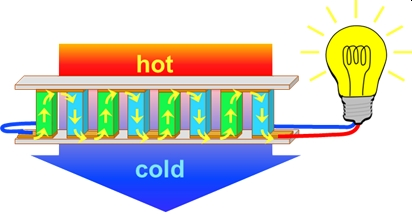

## Key Properties

The performance of a thermoelectric material is characterised by the **dimensionless figure of merit**, *ZT*, defined as:


$$
ZT = \frac{S^2 \sigma T}{\kappa}
$$

Where:
- *S* is the Seebeck coefficient (μV/K)
- *σ* is the electrical conductivity (S/m)
- *T* is the absolute temperature (K)
- *κ* is the thermal conductivity (W/m·K), which includes both lattice and electronic contributions

An ideal thermoelectric material would exhibit:
- A high Seebeck coefficient
- High electrical conductivity
- Low thermal conductivity

However, these properties are often interdependent – for example, increasing electrical conductivity can increase thermal conductivity – making the design of efficient thermoelectric materials a complex challenge.


Note that zT is a composite property – it depends nonlinearly on several underlying quantities (S, σ, κ), which are themselves interrelated. This makes direct prediction of zT challenging and a good example of why domain knowledge is critical when applying ML in materials science.

## Chemical space of thermoelectric materials

We will use the Python package `matminer` (https://matminer.readthedocs.io) to access the materials dataset and featurise the data in a form that is suitable for statistical analysis and building machine learning models. Today we use it to explore thermoelectric materials.

Thermoelectric devices convert temperature differences directly into electrical voltage, enabling applications in power generation and refrigeration. Their efficiency is characterised by the dimensionless figure of merit (zT), which depends on electrical conductivity, Seebeck coefficient, and thermal conductivity (read more [here](https://www.nature.com/articles/nmat2090)). Unlike with bulk modulus, this database contains a lot of information on these materials. Let's explore the diverse compositions that give rise to these properties.

In [ ]:
import matminer  # Materials informatics
from matminer.datasets.dataset_retrieval import load_dataset  # Load materals datasets

print(matminer.datasets.dataset_retrieval.get_all_dataset_info('ucsb_thermoelectrics'))

Compared to the bulk modulus example which uses a small number of manually selected, interpretable features, this dataset includes a large set of automatically generated features. This shift reflects a common challenge in materials science: capturing enough chemical and structural richness for accurate predictions, while managing complexity and interpretability.The dataset is a reasonable size, so we can load it all without downsampling.

In [ ]:
# Use matminer to download the dataset
df = load_dataset('ucsb_thermoelectrics')

print(f'The full dataset contains {df.shape[0]} entries. \n')
print('The DataFrame is shown below:')
df.head(10)

Let's perform a deeper check:

In [ ]:
# Display the columns of the dataset
print("Columns in the dataset:")
print(df.columns)

# Check for any missing values in the dataset
print("\nChecking for missing values:")
print(df.isnull().sum())

First, let's visualise the distribution of the zT performance metric in the dataset. This will help us understand the range and common values.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of zT values
plt.figure(figsize=(5, 4))
sns.histplot(df['zT'], bins=50, kde=True)
plt.title('Thermoelectric figure of merit (zT)')
plt.xlabel('zT (unitless)')
plt.ylabel('Frequency')
plt.show()

What do you think might be a problem if you tried to use this dataset to create a model which predicts high zT materials?

Next, we will analyse the distribution of elements within our thermoelectrics dataset by creating a heatmap over the periodic table. This would take a lot of time from scratch, but we can use the [pymatviz](https://github.com/janosh/pymatviz) package.

In [ ]:
import re
from collections import Counter
from pymatviz import ptable_heatmap

# Extract all unique elements from the composition column
elements = []
for composition in df['composition']:
    # Split each composition by non-alphanumeric characters to extract elements
    elements += [part for part in re.split('[^a-zA-Z]', composition) if part]

# Count the frequency of each element
element_counts = Counter(elements)

# Convert the Counter object to a dictionary for the heatmap
element_counts_dict = dict(element_counts)

# Create the periodic table heatmap
fig = ptable_heatmap(
    element_counts_dict,
    colormap="viridis",
    cbar_label_fmt="Frequency of Elements",
    log=True,  # Use logarithmic scale for better visualisation
    value_kwargs={"fontsize": 10},  # Adjust font size for element labels
    return_type="figure"  # Return the figure for further customisation
)

# Add a title
fig.suptitle("Element Frequency in Thermoelectric Dataset", fontsize=16, fontweight="bold")

# Display the plot
plt.show()

Given that some elements appear much more frequently than others in this dataset, what problems might arise if we try to build a model that predicts thermoelectric performance for materials containing underrepresented elements?

## Unsupervised machine learning

We have a set of materials with different compositions. We can use machine learning to visualise these in two or three dimensions. You can think of this like a materials map.

We refer to the methods that enable us to reduce high-dimensional data into lower dimensions as [dimensionality reduction techniques](https://scikit-learn.org/stable/modules/manifold.html). These allow us to visualise complex data and in this example we will make use of Principal Component Analysis (PCA).

<details>
<summary> Overview of PCA </summary>
PCA is a popular technique for dimensionality reduction and data preprocessing, enabling the simplification of complex datasets. High-dimensional data is transformed into a new coordinate system where the axes align with the directions of maximum variance in the original data. These new axes, termed "principal components," are orthogonal. The first principal component captures the highest variance, the second captures the second highest, etc.

_Key use cases include:_

- **Dimensionality Reduction**: Identifying and eliminating less informative dimensions, reducing noise and computational complexity.

- **Data Visualisation**: Facilitating easier interpretation while preserving essential patterns.

- **Noise Reduction**: Filtering out noise or unimportant variations by focusing on significant variance.

- **Feature Engineering**: A preprocessing step to transform data before applying machine learning algorithms, potentially improving performance.

_PCA workflow:_

1. **Center the Data**: Subtract the mean from each feature to center the data around the origin.

   $
   X_{\text{centered}} = X - \bar{X}
   $

2. **Calculate Covariance Matrix**: Compute the covariance matrix to understand feature relationships and their [covariance](https://en.wikipedia.org/wiki/Covariance).

   $
   \text{Cov}(X) = \frac{1}{n}X_{\text{centered}}^T X_{\text{centered}}
   $

3. **Compute Eigenvalues and Eigenvectors**: Calculate eigenvalues ($\lambda_i$) and eigenvectors ($\mathbf{v}_i$) of the covariance matrix. Eigenvectors represent maximum variance directions, and eigenvalues quantify the variance magnitude.

   $
   \text{Cov}(X) \mathbf{v}_i = \lambda_i \mathbf{v}_i
   $

4. **Sort Eigenvalues**: Sort eigenvalues in descending order, rearranging corresponding eigenvectors accordingly.

5. **Select Principal Components**: Choose a subset of eigenvectors (principal components) based on eigenvalues, explaining the most variance in the data.

6. **Project Data**: Project original data onto selected principal components, yielding a lower-dimensional representation.

Note that PCA analysis is limited by its reliance on linear transformations of the data. In cases where non-linear structures are prominent, alternative techniques such as t-distributed Stochastic Neighbor Embedding (t-SNE) can be used.
</details>

In [ ]:
# Perform PCA analysis
from sklearn.decomposition import PCA
plt.rcdefaults() # Reset the matplotlib style

# Random 10D vectors for demonstration purposes
np.random.seed(42)
num_samples = 1000
dimensionality = 2
random_state = 42
data = np.random.rand(num_samples, dimensionality)

# Perform PCA to reduce the dimensionality to 2D
pca = PCA(n_components=dimensionality)
reduced_data = pca.fit_transform(data)

# Create a color map based on the original data points
   # Use the first dimension of the original data as the color value
color_map = data[:, 0]

# Plot the 2D projection
plt.figure(figsize=(5, 3))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=color_map, cmap='viridis')
plt.colorbar(label='Colour based on first dimension')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D projection using PCA')
plt.show()

#### Featurise compositions

Using our dataset, we can try different featurisation schemes and analyse the resulting visualisations. Here we will perform a Magpie encoding of chemical compositions using the [ElementEmbeddings](https://github.com/WMD-group/ElementEmbeddings) package.

In [ ]:
from elementembeddings.composition import composition_featuriser

magpie_df = composition_featuriser(df, formula_column="composition", embedding='magpie')
magpie_df.head()

Note all of the extra columns that have been added containing the features. We need to do a little cleanup of the DataFrame and can then proceed with our PCA analysis.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Select only the new features by dropping the original columns and handling NaNs
new_features_df = magpie_df.drop(columns=df.columns).dropna()

# Extract feature values
X = new_features_df.values
X_standardised = StandardScaler().fit_transform(X)

# Perform PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(X_standardised)

# Create a single plot for visualisation
fig, ax = plt.subplots(figsize=(6, 4))

# Select a label for coloring (assuming zT column exists in the original df)
color_map = df["zT"].values  # Use original DataFrame for the label (e.g., zT)

# Scatter plot in 2D space
scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], c=color_map, cmap='viridis', alpha=0.25, s=100)

# Add labels and title
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_title("2D PCA of Magpie Features")

# Add colour bar
fig.colorbar(scatter, ax=ax, label="zT")

# Show the plot
plt.show()

That seems to work, but let's check how amount of variance is captured by our two dimensions. Getting above 50% for only two dimensions is fine, but for real applications we may increase the number of components needed to explain a higher threshold (e.g. 80%-90%).

In [ ]:
# Check explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()
print(f"Explained variance by Component 1: {explained_variance[0]:.2f}")
print(f"Explained variance by Component 2: {explained_variance[1]:.2f}")
print(f"Cumulative variance explained by 2 components: {cumulative_variance[1]:.2f}")


Now, wouldn't it be nice if we could see what material each data point refers to. [Plotly](https://plotly.com/python/) can help with that.

In [ ]:
import plotly.express as px

# Add the zT column and composition column from the original DataFrame for coloring and hover info
plot_df = pd.DataFrame(reduced_data, columns=['Component 1', 'Component 2'])
plot_df['zT'] = df['zT'].values
plot_df['composition'] = df['composition'].values  # Assuming this is the column with chemical formulas

# Create an interactive scatter plot using Plotly
fig = px.scatter(
    plot_df,
    x='Component 1',
    y='Component 2',
    color='zT',
    color_continuous_scale='Viridis',
    opacity=0.6,
    hover_name='composition',  # Show chemical formula on hover
    hover_data={'Component 1': ':.2f', 'Component 2': ':.2f', 'zT': ':.2f'},  # Additional hover data
    labels={'zT': 'zT Value'}
)

fig.update_traces(marker=dict(size=10))  # Adjust the size value as needed

fig.update_layout(
    width=6*96,  # 6 inches converted to pixels
    height=4*96  # 4 inches converted to pixels
)

# Show the interactive plot
fig.show()

Finally, let's see how a 3D projection looks.

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

# Perform PCA to reduce dimensionality to 3D
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(X_standardised)

# Create a 3D plot for visualisation
fig = plt.figure(figsize=(6, 5))

# Create a 3D plot
ax = fig.add_subplot(111, projection='3d')
color_map = df["zT"].values
scatter = ax.scatter(reduced_data[:, 0], reduced_data[:, 1], reduced_data[:, 2], c=color_map, cmap='viridis', alpha=0.5)

# Add labels and title
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")
ax.set_title("3D PCA of Magpie Features")

# Show the plot
plt.show()

<details>
<summary> Code hint </summary>
You can change the featurisation scheme to see the impact on the resulting visualisation and distribution of compositions
</details>

### ✅ Summary

In this session, we used machine learning to predict two materials properties:
- **Bulk modulus**, using a small, interpretable feature set
- **Thermoelectric properties**, using a large, high-dimensional descriptor set

Along the way, we encountered some of the core challenges in materials ML:
- **Limited data** and the risk of overfitting
- **Complex descriptors** that make interpretation difficult
- The need for **physically meaningful models**

These are active areas of research, and we hope this gives you a flavour of how AI and materials science intersect.